In [1]:
# ref https://towardsdatascience.com/applying-machine-learning-to-classify-an-unsupervised-text-document-e7bb6265f52

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib as plt
import nltk
import pandas as pd

path = 'Data/1800FLOWERSCOMInc.txt'
path1 = 'Data/2UInc.txt'
path2 = 'Data/3DSystemsCorporation.txt'

file = open(path, "r") 
# print "Output of Readlines after appending"
text = file.readlines()
input_texts = text

In [3]:
# text

In [4]:
split_text = text[0].split(".")
# TODO Determine Best way to split

In [5]:
split_text

['[1] "Item 1A',
 ' Risk Factors',
 ' Cautionary Statements Under the Private Securities Litigation Reform Act of 1995',
 ' Our disclosures and analysis in this Form 10-K contain some forward-looking statements that set forth anticipated results based on management’s plans and assumptions',
 ' From time to time, we also provide forward-looking statements in other statements we release to the public as well as oral forward-looking statements',
 ' Such statements give our current expectations or forecasts of future events; they do not relate strictly to historical or current facts',
 ' We have tried, wherever possible, to identify such statements by using words such as “anticipate,” “estimate,” “expect,” “project,” “intend,” “plan,” “believe” and similar expressions in connection with any discussion of future operating or financial performance',
 ' In particular, these include statements relating to future actions; the effectiveness of our marketing programs; the performance of our exist

In [6]:
vectorizer = TfidfVectorizer(stop_words='english')
# TODO: Custom stopwords, 1-800-flowers returned in multiple slices/formats-> Replace with [name]?
X = vectorizer.fit_transform(split_text)
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit_transform
# 

In [7]:
X

<337x1161 sparse matrix of type '<class 'numpy.float64'>'
	with 3211 stored elements in Compressed Sparse Row format>

In [8]:
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
# https://stackoverflow.com/questions/22961541/python-matplotlib-plot-sparse-matrix-pattern
# this is a randoom sparce matrix , but we can viz ours tomorrow
def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, facecolor ='black')
    ax.plot(m.col, m.row, 's', color='white', ms=3)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax



ax = plot_coo_matrix(X)
ax.figure.show()


C:\Users\xanen\Anaconda3\envs\Tensor\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


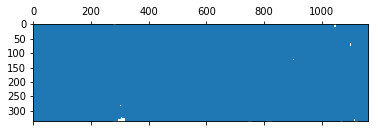

In [9]:
plt.spy(X)

In [10]:

# truek = PLEASE_FIND_ME
truek = 25
model = KMeans(n_clusters=truek, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=25, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [11]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [12]:
nclosest_words_to_show = 5
for i in range(truek):
 print('Cluster %d:' % i),
 for ind in order_centroids[i, :nclosest_words_to_show]:
     print(' %s' % terms[ind])

Cluster 0:
 diminished
 lose
 decline
 com
 brands
Cluster 1:
 company
 25cf
 customers
 products
 business
Cluster 2:
 regardless
 investors
 class
 stock
 common
Cluster 3:
 material
 adverse
 effect
 condition
 financial
Cluster 4:
 card
 debit
 credit
 gift
 fraud
Cluster 5:
 1995
 reform
 act
 private
 securities
Cluster 6:
 net
 pass
 supplier
 credits
 refunds
Cluster 7:
 parties
 confuse
 lost
 customers
 obtain
Cluster 8:
 telecommunications
 systems
 power
 effective
 disaster
Cluster 9:
 acquisitions
 results
 suffer
 acquired
 company
Cluster 10:
 liability
 product
 claims
 costs
 increased
Cluster 11:
 employees
 outsourced
 permanent
 temporary
 staff
Cluster 12:
 contents
 table
 years
 existing
 event
Cluster 13:
 labor
 stoppages
 shipping
 increased
 adversely
Cluster 14:
 com
 damaged
 brands
 expand
 evolving
Cluster 15:
 introduced
 acquired
 continue
 addition
 past
Cluster 16:
 intense
 expects
 competition
 increase
 company
Cluster 17:
 800
 flowers
 strength


In [13]:
print('\n')
print('Prediction')
X = vectorizer.transform(['Market outlook on coffee looks promising'])
predicted = model.predict(X)
print(predicted)




Prediction
[1]


In [14]:
# HOW DO WE FIND OUT WHAT #7 meams?, 1Closest_word to cluster definitely isn't it
for i in range(truek):
 print('Cluster %d:' % i),
 for ind in order_centroids[i, :1]:
     print(' %s' % terms[ind])

Cluster 0:
 diminished
Cluster 1:
 company
Cluster 2:
 regardless
Cluster 3:
 material
Cluster 4:
 card
Cluster 5:
 1995
Cluster 6:
 net
Cluster 7:
 parties
Cluster 8:
 telecommunications
Cluster 9:
 acquisitions
Cluster 10:
 liability
Cluster 11:
 employees
Cluster 12:
 contents
Cluster 13:
 labor
Cluster 14:
 com
Cluster 15:
 introduced
Cluster 16:
 intense
Cluster 17:
 800
Cluster 18:
 analysts
Cluster 19:
 disrupt
Cluster 20:
 standards
Cluster 21:
 1800flowers
Cluster 22:
 promoting
Cluster 23:
 results
Cluster 24:
 flowers


In [15]:
# using joblib to pickle model
from sklearn.externals import joblib
joblib.dump(model,  'doc_cluster.pkl')
model = joblib.load('doc_cluster.pkl')

In [16]:
## TF-IDF analysis 
from nltk.corpus import stopwords

words = text[0].split(" ")
wordSet = []
stopWords = set(stopwords.words('english'))
print(stopWords)
for w in words:
#     wordSet.append(w)

    if w not in stopWords:
        wordSet.append(w)
wordSet

{'or', 'isn', 'that', 'for', 're', 'few', "hadn't", 'their', 'during', 'been', 'some', 'wasn', 'against', 'did', 'our', 'themselves', 've', 'the', 'is', 'are', 'you', 'after', 'his', 'into', 'needn', 'o', "she's", "haven't", 'do', 'under', 'these', "needn't", 'we', 'haven', 'won', 'don', 'such', 'doesn', 'yourselves', 'off', 'd', 'mustn', 'while', 'they', 'each', 'shan', 'out', 'until', 'between', 'has', "mightn't", 'm', "didn't", 'your', 'were', 'him', 'ours', 'how', 'from', 'should', 'me', 'herself', 'because', 'both', 'my', 'its', "aren't", 'hasn', 'y', 'yourself', 'does', 'doing', 'there', 'her', 'i', 'them', "shouldn't", 'a', 'so', 'being', 'not', "you'd", 'have', 'above', 'same', "isn't", 'up', 'down', 'hers', 'why', 'any', "it's", 'once', 'who', 's', 'if', 'over', 'wouldn', 'whom', 'but', 'than', "couldn't", 'very', 'all', "you'll", "you're", 'in', 'aren', 'didn', "shan't", 'ain', 'other', 'further', 'to', 'this', "wasn't", "don't", 'of', 'be', "won't", 'll', 'through', 'here', 

['[1]',
 '"Item',
 '1A.',
 'Risk',
 'Factors.',
 'Cautionary',
 'Statements',
 'Under',
 'Private',
 'Securities',
 'Litigation',
 'Reform',
 'Act',
 '1995.',
 'Our',
 'disclosures',
 'analysis',
 'Form',
 '10-K',
 'contain',
 'forward-looking',
 'statements',
 'set',
 'forth',
 'anticipated',
 'results',
 'based',
 'management’s',
 'plans',
 'assumptions.',
 'From',
 'time',
 'time,',
 'also',
 'provide',
 'forward-looking',
 'statements',
 'statements',
 'release',
 'public',
 'well',
 'oral',
 'forward-looking',
 'statements.',
 'Such',
 'statements',
 'give',
 'current',
 'expectations',
 'forecasts',
 'future',
 'events;',
 'relate',
 'strictly',
 'historical',
 'current',
 'facts.',
 'We',
 'tried,',
 'wherever',
 'possible,',
 'identify',
 'statements',
 'using',
 'words',
 '“anticipate,”',
 '“estimate,”',
 '“expect,”',
 '“project,”',
 '“intend,”',
 '“plan,”',
 '“believe”',
 'similar',
 'expressions',
 'connection',
 'discussion',
 'future',
 'operating',
 'financial',
 'perform

In [17]:
wordDict = dict.fromkeys(wordSet, 0) 
for word in wordSet:
    wordDict[word]+=1
    
pd.DataFrame([wordDict])

,,"""Item",&,(1-800-356-9377)..,(The,"(\""SEC\"").",(e.g.,(http://www.sec.gov),(i),(ii),...,"“1-800-Flowers.com”,",“1-800-Flowers”,“800-Flowers”.,"“anticipate,”",“believe”,"“estimate,”","“expect,”","“intend,”","“plan,”","“project,”"
0,15,1,2,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [18]:
def computeTF(wordDict, split_words):
    tfDict = {}
    word_count = len(split_words)
    for word, count in wordDict.items():
        tfDict[word] = count/float(word_count)
    return tfDict

In [19]:
term_frequency = computeTF(wordDict, words)

In [20]:
term_frequency

{'[1]': 0.00016241676140977748,
 '"Item': 0.00016241676140977748,
 '1A.': 0.00016241676140977748,
 'Risk': 0.00016241676140977748,
 'Factors.': 0.00016241676140977748,
 'Cautionary': 0.00016241676140977748,
 'Statements': 0.00016241676140977748,
 'Under': 0.00032483352281955497,
 'Private': 0.00032483352281955497,
 'Securities': 0.0006496670456391099,
 'Litigation': 0.00048725028422933245,
 'Reform': 0.00032483352281955497,
 'Act': 0.00048725028422933245,
 '1995.': 0.00016241676140977748,
 'Our': 0.0008120838070488875,
 'disclosures': 0.00032483352281955497,
 'analysis': 0.00016241676140977748,
 'Form': 0.0009745005684586649,
 '10-K': 0.00032483352281955497,
 'contain': 0.00048725028422933245,
 'forward-looking': 0.0008120838070488875,
 'statements': 0.0009745005684586649,
 'set': 0.00016241676140977748,
 'forth': 0.00016241676140977748,
 'anticipated': 0.00016241676140977748,
 'results': 0.005359753126522657,
 'based': 0.00016241676140977748,
 'management’s': 0.00032483352281955497,
 

In [21]:
def computeIDF(docList):
    import math
    idfDict = {}
    N = len(docList)
    print(N)
    idfDict = dict.fromkeys(docList[0].keys(), 0)
    for doc in docList:
        for word, val in doc.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log10(N / float(val))
        
    return idfDict

In [22]:
idfs = computeIDF([term_frequency])

# This isnt working? Maybe only one doc?
idfs

1


{'[1]': 0.0,
 '"Item': 0.0,
 '1A.': 0.0,
 'Risk': 0.0,
 'Factors.': 0.0,
 'Cautionary': 0.0,
 'Statements': 0.0,
 'Under': 0.0,
 'Private': 0.0,
 'Securities': 0.0,
 'Litigation': 0.0,
 'Reform': 0.0,
 'Act': 0.0,
 '1995.': 0.0,
 'Our': 0.0,
 'disclosures': 0.0,
 'analysis': 0.0,
 'Form': 0.0,
 '10-K': 0.0,
 'contain': 0.0,
 'forward-looking': 0.0,
 'statements': 0.0,
 'set': 0.0,
 'forth': 0.0,
 'anticipated': 0.0,
 'results': 0.0,
 'based': 0.0,
 'management’s': 0.0,
 'plans': 0.0,
 'assumptions.': 0.0,
 'From': 0.0,
 'time': 0.0,
 'time,': 0.0,
 'also': 0.0,
 'provide': 0.0,
 'release': 0.0,
 'public': 0.0,
 'well': 0.0,
 'oral': 0.0,
 'statements.': 0.0,
 'Such': 0.0,
 'give': 0.0,
 'current': 0.0,
 'expectations': 0.0,
 'forecasts': 0.0,
 'future': 0.0,
 'events;': 0.0,
 'relate': 0.0,
 'strictly': 0.0,
 'historical': 0.0,
 'facts.': 0.0,
 'We': 0.0,
 'tried,': 0.0,
 'wherever': 0.0,
 'possible,': 0.0,
 'identify': 0.0,
 'using': 0.0,
 'words': 0.0,
 '“anticipate,”': 0.0,
 '“estim

In [23]:
def computeTFIDF(term_frequency, idfs):
    tfidf = {}
    for word, val in term_frequency.items():
        tfidf[word] = val*idfs[word]
    return tfidf

In [24]:
tfidfBow = computeTFIDF(term_frequency, idfs)


In [25]:
tfidfBow


{'[1]': 0.0,
 '"Item': 0.0,
 '1A.': 0.0,
 'Risk': 0.0,
 'Factors.': 0.0,
 'Cautionary': 0.0,
 'Statements': 0.0,
 'Under': 0.0,
 'Private': 0.0,
 'Securities': 0.0,
 'Litigation': 0.0,
 'Reform': 0.0,
 'Act': 0.0,
 '1995.': 0.0,
 'Our': 0.0,
 'disclosures': 0.0,
 'analysis': 0.0,
 'Form': 0.0,
 '10-K': 0.0,
 'contain': 0.0,
 'forward-looking': 0.0,
 'statements': 0.0,
 'set': 0.0,
 'forth': 0.0,
 'anticipated': 0.0,
 'results': 0.0,
 'based': 0.0,
 'management’s': 0.0,
 'plans': 0.0,
 'assumptions.': 0.0,
 'From': 0.0,
 'time': 0.0,
 'time,': 0.0,
 'also': 0.0,
 'provide': 0.0,
 'release': 0.0,
 'public': 0.0,
 'well': 0.0,
 'oral': 0.0,
 'statements.': 0.0,
 'Such': 0.0,
 'give': 0.0,
 'current': 0.0,
 'expectations': 0.0,
 'forecasts': 0.0,
 'future': 0.0,
 'events;': 0.0,
 'relate': 0.0,
 'strictly': 0.0,
 'historical': 0.0,
 'facts.': 0.0,
 'We': 0.0,
 'tried,': 0.0,
 'wherever': 0.0,
 'possible,': 0.0,
 'identify': 0.0,
 'using': 0.0,
 'words': 0.0,
 '“anticipate,”': 0.0,
 '“estim

In [26]:
import collections
collections.Counter(tfidfBow).most_common(30)


[('[1]', 0.0),
 ('"Item', 0.0),
 ('1A.', 0.0),
 ('Risk', 0.0),
 ('Factors.', 0.0),
 ('Cautionary', 0.0),
 ('Statements', 0.0),
 ('Under', 0.0),
 ('Private', 0.0),
 ('Securities', 0.0),
 ('Litigation', 0.0),
 ('Reform', 0.0),
 ('Act', 0.0),
 ('1995.', 0.0),
 ('Our', 0.0),
 ('disclosures', 0.0),
 ('analysis', 0.0),
 ('Form', 0.0),
 ('10-K', 0.0),
 ('contain', 0.0),
 ('forward-looking', 0.0),
 ('statements', 0.0),
 ('set', 0.0),
 ('forth', 0.0),
 ('anticipated', 0.0),
 ('results', 0.0),
 ('based', 0.0),
 ('management’s', 0.0),
 ('plans', 0.0),
 ('assumptions.', 0.0)]

In [27]:
collections.Counter(term_frequency).most_common(30)



[('may', 0.01932759460776352),
 ('Company’s', 0.014130258242650642),
 ('Company', 0.013967841481240865),
 ('The', 0.009095338638947539),
 ('could', 0.008932921877537761),
 ('customers', 0.00584700341075199),
 ('results', 0.005359753126522657),
 ('If', 0.005034919603703102),
 ('<U+25CF>', 0.004222835796654215),
 ('\\t\\t\\t', 0.004222835796654215),
 ('products', 0.004060419035244438),
 ('customer', 0.0038980022738346596),
 ('significant', 0.0030859184667857724),
 ('In', 0.002923501705375995),
 ('ability', 0.002923501705375995),
 ('use', 0.002923501705375995),
 ('operating', 0.0025986681825564397),
 ('result', 0.0025986681825564397),
 ('number', 0.0025986681825564397),
 ('affect', 0.0025986681825564397),
 ('information', 0.0025986681825564397),
 ('future', 0.002436251421146662),
 ('financial', 0.002436251421146662),
 ('', 0.002436251421146662),
 ('maintain', 0.002436251421146662),
 ('third', 0.002436251421146662),
 ('parties', 0.0022738346597368847),
 ('property', 0.0022738346597368847),

In [28]:
# Latent Dirichlet Allocation
# Ref http://brandonrose.org/clustering
# LDA is a probabilistic topic model that assumes documents
# are a mixture of topics and that each word in the document is attributable to the document's topics.
from nltk.stem.snowball import SnowballStemmer
import re
stemmer = SnowballStemmer("english")
import nltk
nltk.download('stopwords')
 
stopwords = nltk.corpus.stopwords.words('english')

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns
from gensim import corpora, models, similarities 

#remove proper names0
%time preprocess = [strip_proppers(doc) for doc in input_texts]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]
# print(texts)
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)
# print(dictionary)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
# dictionary.filter_extremes(no_below=1, no_above=0.8)  THIS FILTERS EVERYTHING OUT
# print(dictionary)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]
# print(corpus)
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xanen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Wall time: 138 ms
Wall time: 174 ms
Wall time: 18.9 ms
Wall time: 973 ms


In [29]:
lda.show_topics()


[(0,
  '0.001*"may" + 0.001*"custom" + 0.001*"result" + 0.001*"product" + 0.001*"busi" + 0.001*"signific" + 0.001*"could" + 0.001*"oper" + 0.001*"secret" + 0.001*"free"'),
 (1,
  '0.001*"may" + 0.001*"fragment" + 0.001*"free" + 0.001*"scenario" + 0.001*"forth" + 0.001*"forward" + 0.001*"fourth" + 0.001*"scope" + 0.001*"function" + 0.001*"robust"'),
 (2,
  '0.034*"may" + 0.020*"custom" + 0.016*"result" + 0.016*"could" + 0.014*"product" + 0.012*"busi" + 0.011*"oper" + 0.008*"\\t\\t\\t" + 0.008*"system" + 0.007*"number"'),
 (3,
  '0.001*"may" + 0.001*"fourth" + 0.001*"sabotag" + 0.001*"forese" + 0.001*"scenario" + 0.001*"forth" + 0.001*"forward" + 0.001*"forecast" + 0.001*"frost" + 0.001*"free"'),
 (4,
  '0.001*"may" + 0.001*"fragment" + 0.001*"free" + 0.001*"scenario" + 0.001*"forth" + 0.001*"forward" + 0.001*"fourth" + 0.001*"scope" + 0.001*"function" + 0.001*"robust"')]

In [30]:
topics_matrix = lda.show_topics(formatted=False, num_words=15)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,1]
for i in topic_words:
    print([str(word[0]) for word in i])
    print()

['may', 'custom', 'result', 'product', 'could', 'oper', 'busi', 'signific', 'secret', 'free', 'frost', 'sentiment', 'selection..', 'futur', 'furthermor']

['may', 'scope', 'forc', 'function', 'frost', 'robust', 'free', 'sabotag', 'fragment', 'fourth', 'forward', 'forth', 'scenario', 'forese', 'furthermor']

['may', 'custom', 'result', 'could', 'product', 'busi', 'oper', '\\t\\t\\t', 'system', 'number', 'futur', 'parti', 'servic', 'signific', 'use']

['may', 'forecast', 'search', 'frost', 'robust', 'free', 'sabotag', 'fragment', 'fourth', 'forward', 'forth', 'scenario', 'forese', 'scope', 'fungi']

['may', 'scope', 'forc', 'function', 'frost', 'robust', 'free', 'sabotag', 'fragment', 'fourth', 'forward', 'forth', 'scenario', 'forese', 'furthermor']



In [31]:
# print(corpus)
lsi = models.lsimodel.LsiModel(corpus, num_topics=5, id2word=dictionary, chunksize=10000)
topics_matrix = lsi.show_topics(formatted=False, num_words=15)
topics_matrix = np.array(topics_matrix)
topic_words = topics_matrix[:,1]
for i in topic_words:
    print([str(word[0]) for word in i])
    print()

['may', 'custom', 'result', 'could', 'product', 'busi', 'oper', '\\t\\t\\t', 'system', 'number', 'signific', 'servic', 'futur', 'use', 'parti']

